In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### 1. Getting Orginal Data

In [30]:
#functions
def get_data(stock_name,start_date,end_date):
    data = yf.download(stock_name, start=start_date, end=end_date)
    return data

def add_time_step(data,start_step = 0):
    tmp = data.copy()
    tmp['Time_Step'] = np.arange(len(tmp.index))+start_step
    return tmp

def create_lag(data, i):
    tmp = data.copy()
    data['Lag_'+str(i)] = data['Close'].shift(i)
    return tmp

def plot_close(data,index = True):
    fig, ax = plt.subplots()
    if index:
        ax.plot(data.index, data.Close)
        #ax.plot(data.index, data['Adj Close'])
    else:
        ax.plot(data.Time_Step, data.Close)
    plt.show()
    return

[*********************100%%**********************]  1 of 1 completed


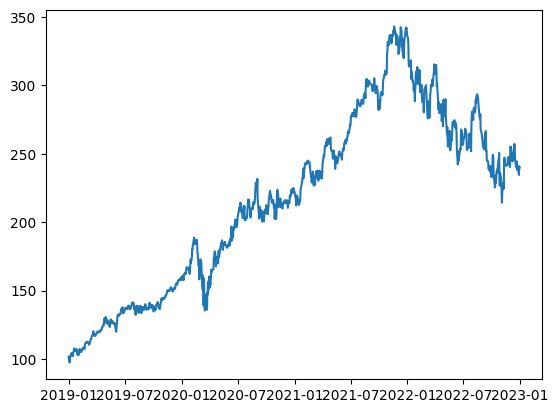

,Open,High,Low,Close,Adj Close,Volume,Time_Step
Date,,,,,,,
2018-12-31,101.290001,102.400002,100.440002,101.570000,96.450592,33173800,0
2019-01-02,99.550003,101.750000,98.940002,101.120003,96.023254,35329300,1
2019-01-03,100.099998,100.190002,97.199997,97.400002,92.490768,42579100,2
2019-01-04,99.720001,102.510002,98.930000,101.930000,96.792458,44060600,3
2019-01-07,101.639999,103.269997,100.980003,102.059998,96.915901,35656100,4


In [31]:
stock_name = 'MSFT'
start_date = '2018-12-31'
end_date = '2022-12-31'

train_data = get_data(stock_name,start_date,end_date)

plot_close(train_data)

train_data = add_time_step(train_data)

train_data.head()

In [32]:
#scale data
scaler = StandardScaler()
scaler = scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)

[[-1.76865317 -1.7695116  -1.76576265 ... -1.75910562  0.25934476
  -1.73033506]
 [-1.79529195 -1.77936664 -1.78900145 ... -1.76563521  0.4289542
  -1.72690185]
 [-1.7868717  -1.80301865 -1.81595853 ... -1.81961059  0.99941793
  -1.72346865]
 ...
 [ 0.30733645  0.31247463  0.30605329 ...  0.31921237 -0.97735243
   1.72346865]
 [ 0.28835239  0.34583003  0.32898217 ...  0.41735473 -0.79530259
   1.72690185]
 [ 0.32754531  0.31611349  0.34462977 ...  0.39933177 -0.6247253
   1.73033506]]


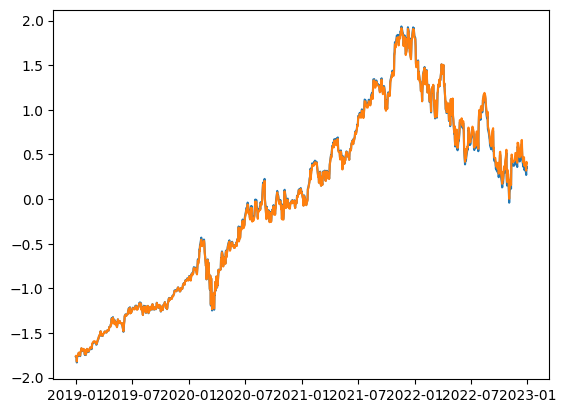

In [33]:
print(train_data_scaled)

fig, ax = plt.subplots()
ax.plot(train_data.index,train_data_scaled[:,3])
ax.plot(train_data.index,train_data_scaled[:,4])
plt.show()

### 2. Getting Trend

In [34]:
#function
def plot_trend(data):
    fig, ax = plt.subplots()
    ax.plot('Time_Step', 'Close', data=data, color='0.75')
    ax = sns.regplot(x='Time_Step', y='Close', data=data, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title('Time PLot of Time Step')
    plt.show()

def get_trend(data, degree = 1):
    trend = np.polyfit(data['Time_Step'],data['Close'],degree)
    return trend

def get_trend_array(data, degree = 1):
    trend = np.polyfit(data[:,6],data[:,3],degree)
    return trend

def remove_trend(data):
    remove_data = data.copy()
    trend = get_trend(data)
    remove_data.Close = remove_data.Close - remove_data.Time_Step * trend[0] - trend[1]
    return remove_data, trend

def remove_trend1(data,trend):
    remove_data = data.copy()
    remove_data.Close = remove_data.Close - remove_data.Time_Step * trend[0] - trend[1]
    return remove_data

[8.74423330e-01 5.59222491e-17]


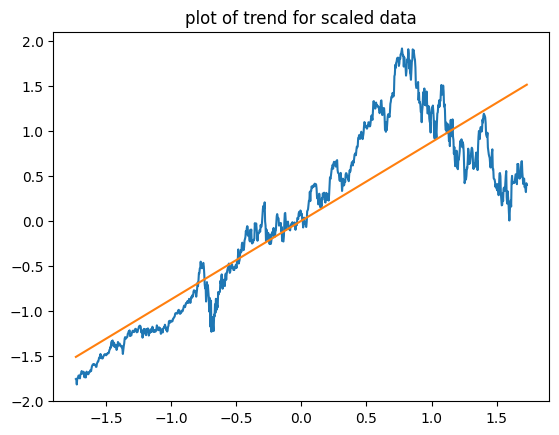

(1009, 7)


In [35]:
trend = get_trend_array(train_data_scaled)
print(trend)

fig, ax = plt.subplots()
ax.plot(train_data_scaled[:,6],train_data_scaled[:,4])
ax.plot(train_data_scaled[:,6],train_data_scaled[:,6]*trend[0]+trend[1])
ax.set_title('plot of trend for scaled data')
plt.show()

print(train_data_scaled.shape)

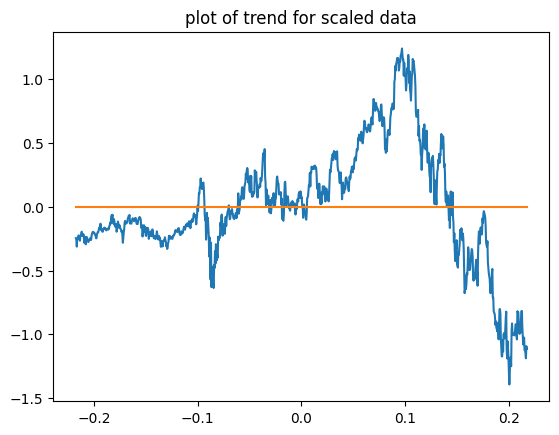

In [36]:
#remove trend
def remove_trend_array(input_data,trend):
    data = input_data
    for i in range(data.shape[1]):
        data[:,i] = data[:,i] - trend[0]*data[:,6] - trend[1]
    return data

no_trend_data = remove_trend_array(train_data_scaled,trend)

new_trend = get_trend_array(no_trend_data)

fig, ax = plt.subplots()
ax.plot(no_trend_data[:,6],no_trend_data[:,4])
ax.plot(no_trend_data[:,6],no_trend_data[:,6]*new_trend[0]+new_trend[1])
ax.set_title('plot of trend for scaled data')
plt.show()

### 3. Getting Season

In [37]:
#functions
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

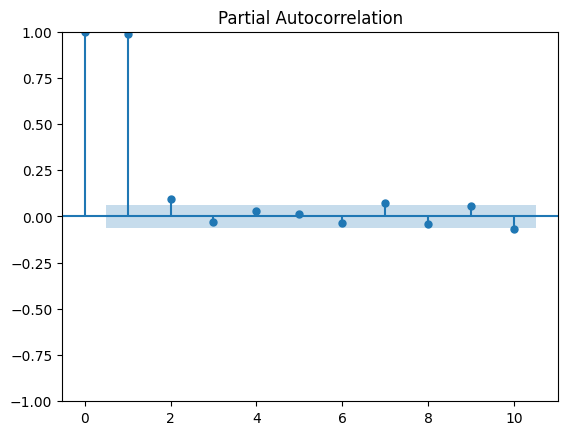

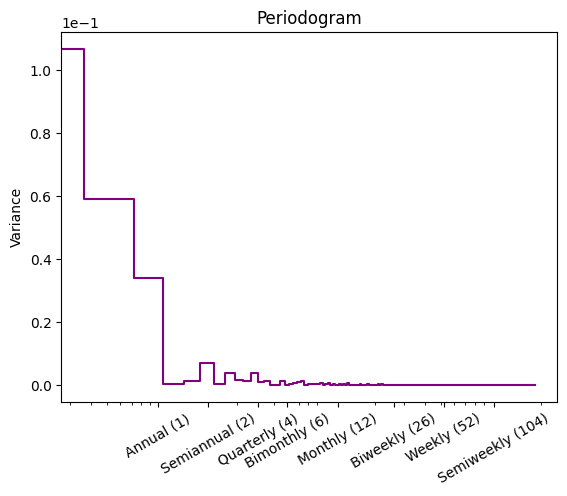

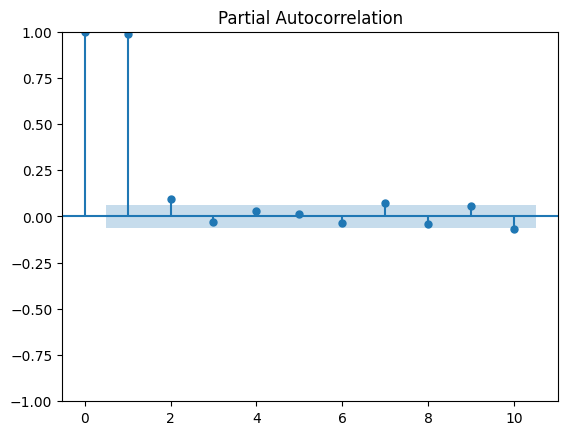

In [38]:
plot_periodogram(no_trend_data[:,3])
plot_pacf(no_trend_data[:,3], lags=10)

### 4. Training


In [39]:
data_for_train = no_trend_data

In [40]:
num_future = 10
num_past = 20

trainX = []
trainy = []

for i in range(num_past, len(data_for_train) - num_future + 1):
    trainX.append(data_for_train[i - num_past:i, :7])
    trainy.append(data_for_train[i :i+num_future,3])

trainX, trainy = np.array(trainX), np.array(trainy)

print(data_for_train.shape)
print(trainX.shape)
print(trainy.shape)

(1009, 7)
(980, 20, 7)
(980, 10)


In [41]:
print(data_for_train)
print('split')
print(trainy[1,:])

[[-0.25560783 -0.25646626 -0.25271731 ... -0.24606028  1.7723901
  -0.21728971]
 [-0.28524868 -0.26932337 -0.27895818 ... -0.25559195  1.93899747
  -0.21685858]
 [-0.27983051 -0.29597745 -0.30891734 ... -0.31256939  2.50645912
  -0.21642745]
 ...
 [-1.19970475 -1.19456656 -1.20098791 ... -1.18782883 -2.48439362
   0.21642745]
 [-1.22169088 -1.16421324 -1.1810611  ... -1.09268854 -2.30534586
   0.21685858]
 [-1.18550003 -1.19693185 -1.16841557 ... -1.11371357 -2.13777064
   0.21728971]]
split
[-0.27273618 -0.30101705 -0.25867055 -0.23899828 -0.26023175 -0.27487741
 -0.27175128 -0.28118792 -0.25906443 -0.26329217]


In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(trainX, trainy, test_size=0.2, random_state=42, shuffle=True)
#y_train = y_train.reshape(380,10,1)
#y_valid = y_valid.reshape(95,10,1)

In [43]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(784, 20, 7)
(196, 20, 7)
(784, 10)
(196, 10)


In [44]:
model = keras.Sequential([
    layers.LSTM(64,activation='relu',input_shape=(20,7),return_sequences=True),
    #layers.LSTM(64,activation='relu',return_sequences=True),
    layers.LSTM(64,activation='relu',return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(10),
])

model.compile(
    optimizer='adam',
    loss='mse',
)

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size = 16,
    epochs = 500,
    callbacks = [early_stopping],
    verbose = 1,
)

Epoch 1/500
49/49 [==============================] - 1s 7ms/step - loss: 0.1058 - val_loss: 0.0404
Epoch 2/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0473 - val_loss: 0.0291
Epoch 3/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0444 - val_loss: 0.0280
Epoch 4/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0367 - val_loss: 0.0291
Epoch 5/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0375 - val_loss: 0.0268
Epoch 6/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0327 - val_loss: 0.0235
Epoch 7/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0330 - val_loss: 0.0241
Epoch 8/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0311 - val_loss: 0.0234
Epoch 9/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0302 - val_loss: 0.0208
Epoch 10/500
49/49 [==============================] - 0s 5ms/step - loss: 0.0325 - val_loss: 0.0191
Epoch 11/

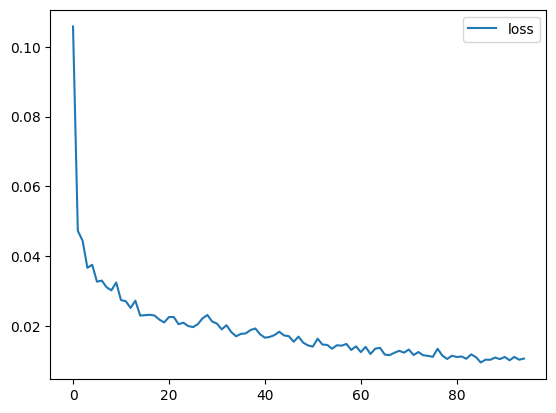

In [45]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot();

31/31 [==============================] - 0s 2ms/step
(980, 10)


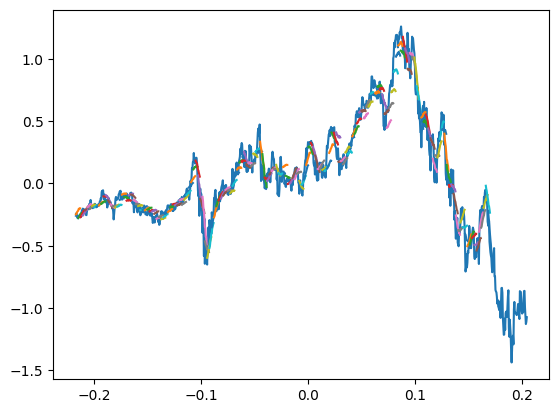

In [46]:
predictions = model.predict(trainX)
print(predictions.shape)

pred_array = np.array([9,8,7,6,5,4,3,2,1,0])
fig, ax = plt.subplots()
ax.plot(trainX[:,0,-1], trainy[:,3])
for i in range(900):
    if i % 5 == 0:
        ax.plot(trainX[i:i+10,0,-1],predictions[i,:])
plt.show()

### 5. Error 

In [47]:
train_data.tail(45)

,Open,High,Low,Close,Adj Close,Volume,Time_Step
Date,,,,,,,
2022-10-27,231.039993,233.690002,225.779999,226.750000,224.125488,40424600,964
2022-10-28,226.240005,236.600006,226.050003,235.869995,233.139908,40647700,965
2022-10-31,233.759995,234.919998,231.149994,232.130005,229.443222,28357300,966
2022-11-01,234.600006,235.740005,227.330002,228.169998,225.529022,30592300,967
2022-11-02,229.460007,231.300003,220.039993,220.100006,217.552444,38407000,968
2022-11-03,220.089996,220.410004,213.979996,214.250000,211.770157,36633900,969
2022-11-04,217.550003,221.589996,213.429993,221.389999,218.827515,36789100,970
2022-11-07,221.990005,228.410004,221.279999,227.869995,225.232513,33498000,971
2022-11-08,228.699997,231.649994,225.839996,228.869995,226.220932,28192500,972


### 6. Testing

In [48]:
test_start_date = '2022-10-31'
test_end_date = '2023-12-31'

test_data = get_data(stock_name,test_start_date,test_end_date)
test_data = add_time_step(test_data,966)
test_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Time_Step
Date,,,,,,,
2022-10-31,233.759995,234.919998,231.149994,232.130005,229.443207,28357300,966
2022-11-01,234.600006,235.740005,227.330002,228.169998,225.529037,30592300,967
2022-11-02,229.460007,231.300003,220.039993,220.100006,217.552460,38407000,968
2022-11-03,220.089996,220.410004,213.979996,214.250000,211.770142,36633900,969
2022-11-04,217.550003,221.589996,213.429993,221.389999,218.827530,36789100,970


In [49]:
test_data_scaled = scaler.transform(test_data)
print(test_data_scaled)
no_trend_test_data = remove_trend_array(test_data_scaled,trend)
print('split')
print(no_trend_test_data)

[[ 0.25941714  0.23969907  0.25926578 ...  0.2729834  -0.11965032
   1.58614047]
 [ 0.27227743  0.25213167  0.20008444 ...  0.21317601  0.05621472
   1.58957367]
 [ 0.1935858   0.18481428  0.08714377 ...  0.09129619  0.67112864
   1.59300688]
 ...
 [ 2.40169773  2.36444091  2.45393761 ...  2.48283944 -1.17813759
   2.58176977]
 [ 2.42741784  2.38566701  2.47485262 ...  2.50132776 -1.22365005
   2.58520297]
 [ 2.437063    2.3962803   2.46431781 ...  2.51294049 -0.87774278
   2.58863618]]
split
[[-1.12754109 -1.14725916 -1.12769245 ... -1.11397483 -1.50660855
   0.19918224]
 [-1.11768287 -1.13782864 -1.18987586 ... -1.17678429 -1.33374558
   0.19961337]
 [-1.19937658 -1.2081481  -1.30581861 ... -1.30166618 -0.72183374
   0.2000445 ]
 ...
 [ 0.14413801  0.1068812   0.19637789 ...  0.22527972 -3.43569731
   0.32421005]
 [ 0.16685605  0.12510522  0.21429083 ...  0.24076597 -3.48421184
   0.32464118]
 [ 0.17349914  0.13271643  0.20075394 ...  0.24937663 -3.14130664
   0.32507231]]


In [50]:
trainX_test = []
trainy_test = []

for i in range(num_past, len(no_trend_test_data) - num_future + 1):
    trainX_test.append(no_trend_test_data[i - num_past:i, :])
    trainy_test.append(no_trend_test_data[i :i+num_future,3])

trainX_test, trainy_test = np.array(trainX_test), np.array(trainy_test)

In [51]:
test_predictions = model.predict(trainX_test)
print(test_predictions.shape)
print(trainX_test.shape)
print(trainy_test.shape)
print(no_trend_test_data.shape)

9/9 [==============================] - 0s 2ms/step
(264, 10)
(264, 20, 7)
(264, 10)
(293, 7)


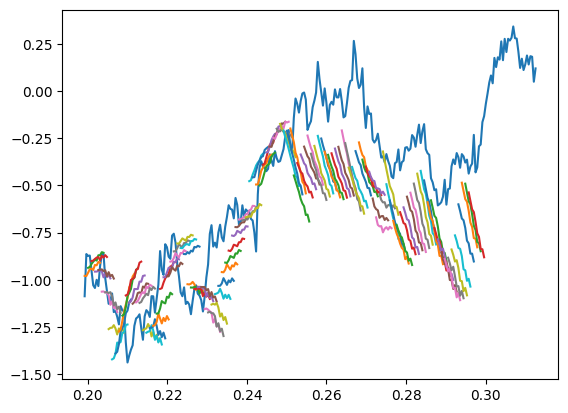

In [53]:
fig, ax = plt.subplots()
for j in range(1):
    ax.plot(trainX_test[:,0,-1], trainy_test[:,j])
for i in range(226):
    if i % 2 == 0:
        ax.plot(trainX_test[i:i+10,0,-1],test_predictions[i,:])
plt.show()